In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
import librosa.display
import os
from scipy.io import wavfile
from scipy.signal import spectrogram
from scipy.stats import kurtosis, skew


In [2]:
y_train = pd.read_csv("data/Y_train_ofTdMHi.csv")

# 1. EDA

## Analyze the target variable

In [3]:
y_train.head()

,id,pos_label
0,00000-JAM.wav,0.0
1,00001-JAM.wav,1.0
2,00002-JAM.wav,1.0
3,00003-JAM.wav,1.0
4,00004-JAM.wav,1.0


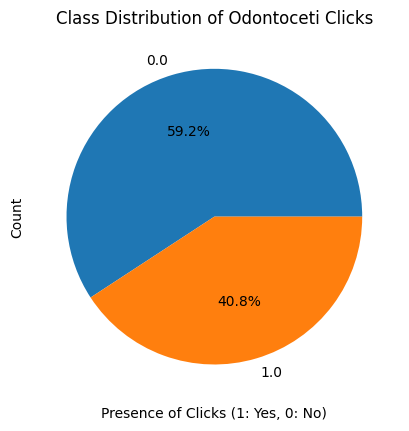

In [4]:
#Visualize the repartition of the target variable 
y_train['pos_label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Class Distribution of Odontoceti Clicks")
plt.xlabel("Presence of Clicks (1: Yes, 0: No)")
plt.ylabel("Count")
plt.show()


In [5]:
# Extract location information from file names
y_train["location"] = y_train["id"].apply(lambda x: x.split("-")[-1].split(".")[0])

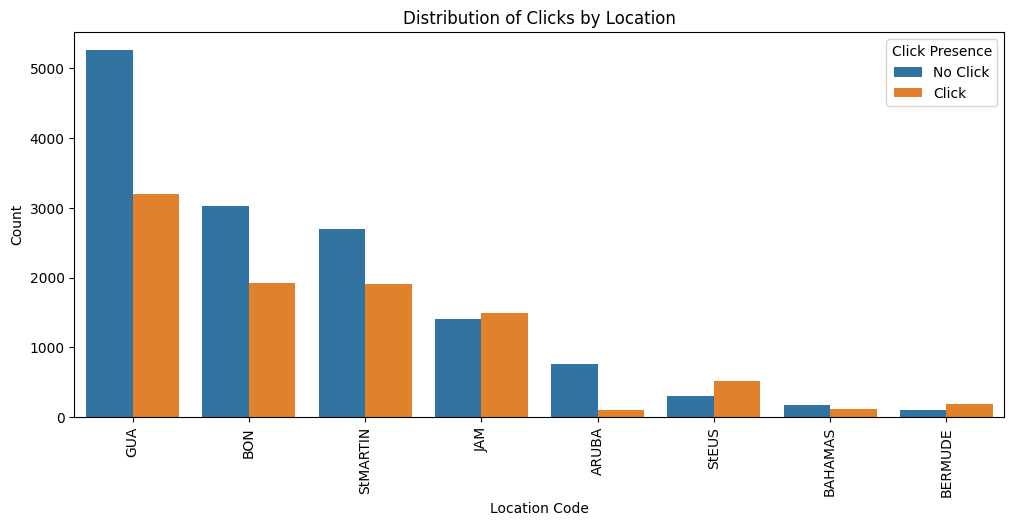

In [6]:
# Location-based distribution plot
plt.figure(figsize=(12, 5))
sns.countplot(x=y_train["location"], hue=y_train["pos_label"], order=y_train["location"].value_counts().index)
plt.xticks(rotation=90)
plt.title("Distribution of Clicks by Location")
plt.xlabel("Location Code")
plt.ylabel("Count")
plt.legend(title="Click Presence", labels=["No Click", "Click"])
plt.show()

Certain locations may have more odontoceti clicks, indicating regional differences in marine life activity.

## Audio Data Exploration

Nous allons prendre les même variables que le benchmark du challenge pour commencer

In [8]:
# Charger les fichiers audio
audio_files = [os.path.join("data/X_train", f) for f in os.listdir("data/X_train") if f.endswith(".wav")]

audio_properties = []

for file in audio_files:
    y, sr = librosa.load(file, sr=None)  # Charger l'audio avec la fréquence d'échantillonnage originale
    duration = len(y) / sr

    # Amplitude (statistiques)
    amp_mean, amp_std, amp_min, amp_max = np.mean(y), np.std(y), np.min(y), np.max(y)

    # Puissance RMS
    rms = librosa.feature.rms(y=y)
    rms_mean, rms_std, rms_min, rms_max = np.mean(rms), np.std(rms), np.min(rms), np.max(rms)

    # Spectral Centroid
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    centroid_mean, centroid_std, centroid_min, centroid_max = np.mean(centroid), np.std(centroid), np.min(centroid), np.max(centroid)

    # Spectral Bandwidth
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    bandwidth_mean, bandwidth_std, bandwidth_min, bandwidth_max = np.mean(bandwidth), np.std(bandwidth), np.min(bandwidth), np.max(bandwidth)

    # Spectral Flatness
    flatness = librosa.feature.spectral_flatness(y=y)
    flatness_mean, flatness_std, flatness_min, flatness_max = np.mean(flatness), np.std(flatness), np.min(flatness), np.max(flatness)

    # FFT pour trouver la fréquence de pic
    D = np.abs(librosa.stft(y))
    freqs = librosa.fft_frequencies(sr=sr)
    peak_freq = freqs[np.argmax(np.mean(D, axis=1))]

    # Inter-Click Interval (ICI)
    onset_frames = librosa.onset.onset_detect(y=y, sr=sr, backtrack=True)
    onset_times = librosa.frames_to_time(onset_frames, sr=sr)
    ici_values = np.diff(onset_times)
    mean_ici = np.mean(ici_values) if len(ici_values) > 0 else 0

    # Signal-to-Noise Ratio (SNR)
    signal_power = np.mean(y**2)
    noise_power = np.var(y)
    snr = 10 * np.log10(signal_power / noise_power)

    # Kurtosis & Skewness du spectre
    spec = np.abs(librosa.stft(y))
    spec_mean = np.mean(spec, axis=1)
    kurt = kurtosis(spec_mean)
    skewness = skew(spec_mean)

    # Stocker les propriétés
    audio_properties.append([
        file, sr, duration, peak_freq, mean_ici, snr, kurt, skewness,
        amp_mean, amp_std, amp_min, amp_max,
        rms_mean, rms_std, rms_min, rms_max,
        centroid_mean, centroid_std, centroid_min, centroid_max,
        bandwidth_mean, bandwidth_std, bandwidth_min, bandwidth_max,
        flatness_mean, flatness_std, flatness_min, flatness_max
    ])

# Créer un DataFrame
columns = [
    "File", "Sampling Rate (Hz)", "Duration (s)", "Peak Frequency", "Mean ICI (s)", "SNR (dB)", "Kurtosis", "Skewness",
    "Amplitude Mean", "Amplitude Std", "Amplitude Min", "Amplitude Max",
    "RMS Mean", "RMS Std", "RMS Min", "RMS Max",
    "Spectral Centroid Mean", "Spectral Centroid Std", "Spectral Centroid Min", "Spectral Centroid Max",
    "Spectral Bandwidth Mean", "Spectral Bandwidth Std", "Spectral Bandwidth Min", "Spectral Bandwidth Max",
    "Spectral Flatness Mean", "Spectral Flatness Std", "Spectral Flatness Min", "Spectral Flatness Max"
]

audio_df = pd.DataFrame(audio_properties, columns=columns)


/Users/maro/projet_dl/venv/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


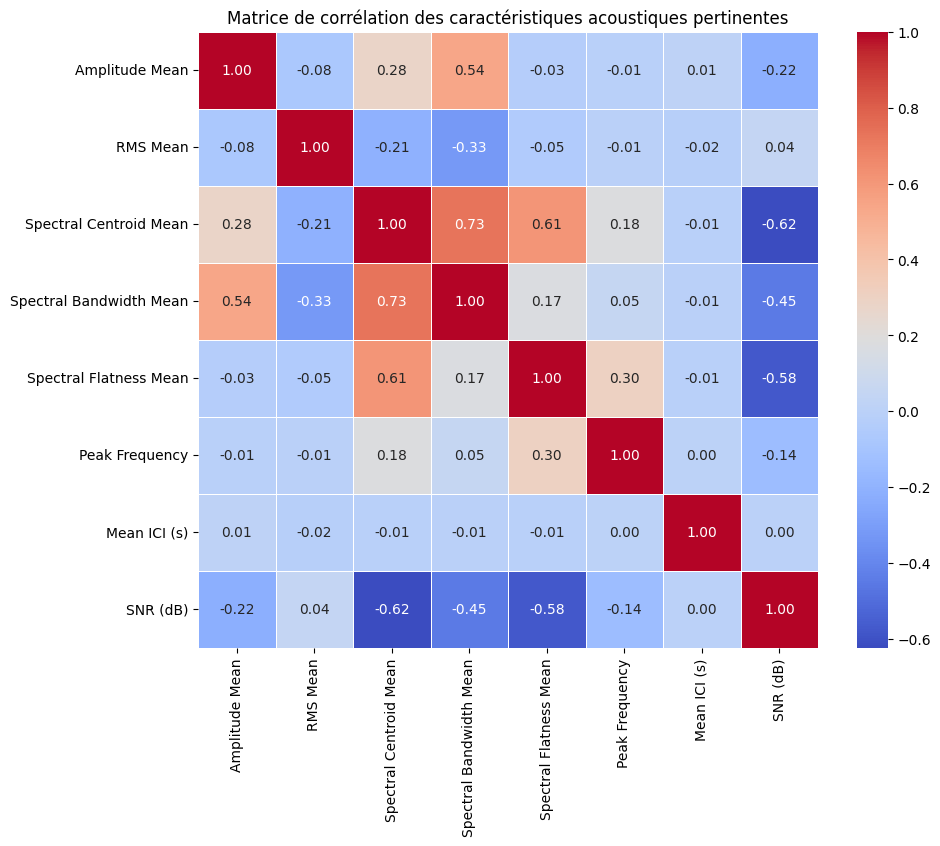

In [9]:
# On garde que les mean pour l'analyse car sinon trop de répétition
selected_features = [
    "Amplitude Mean", "RMS Mean", "Spectral Centroid Mean", 
    "Spectral Bandwidth Mean", "Spectral Flatness Mean", "Peak Frequency",
    "Mean ICI (s)", "SNR (dB)"
]


corr_matrix = audio_df[selected_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matrice de corrélation des caractéristiques acoustiques pertinentes")
plt.show()


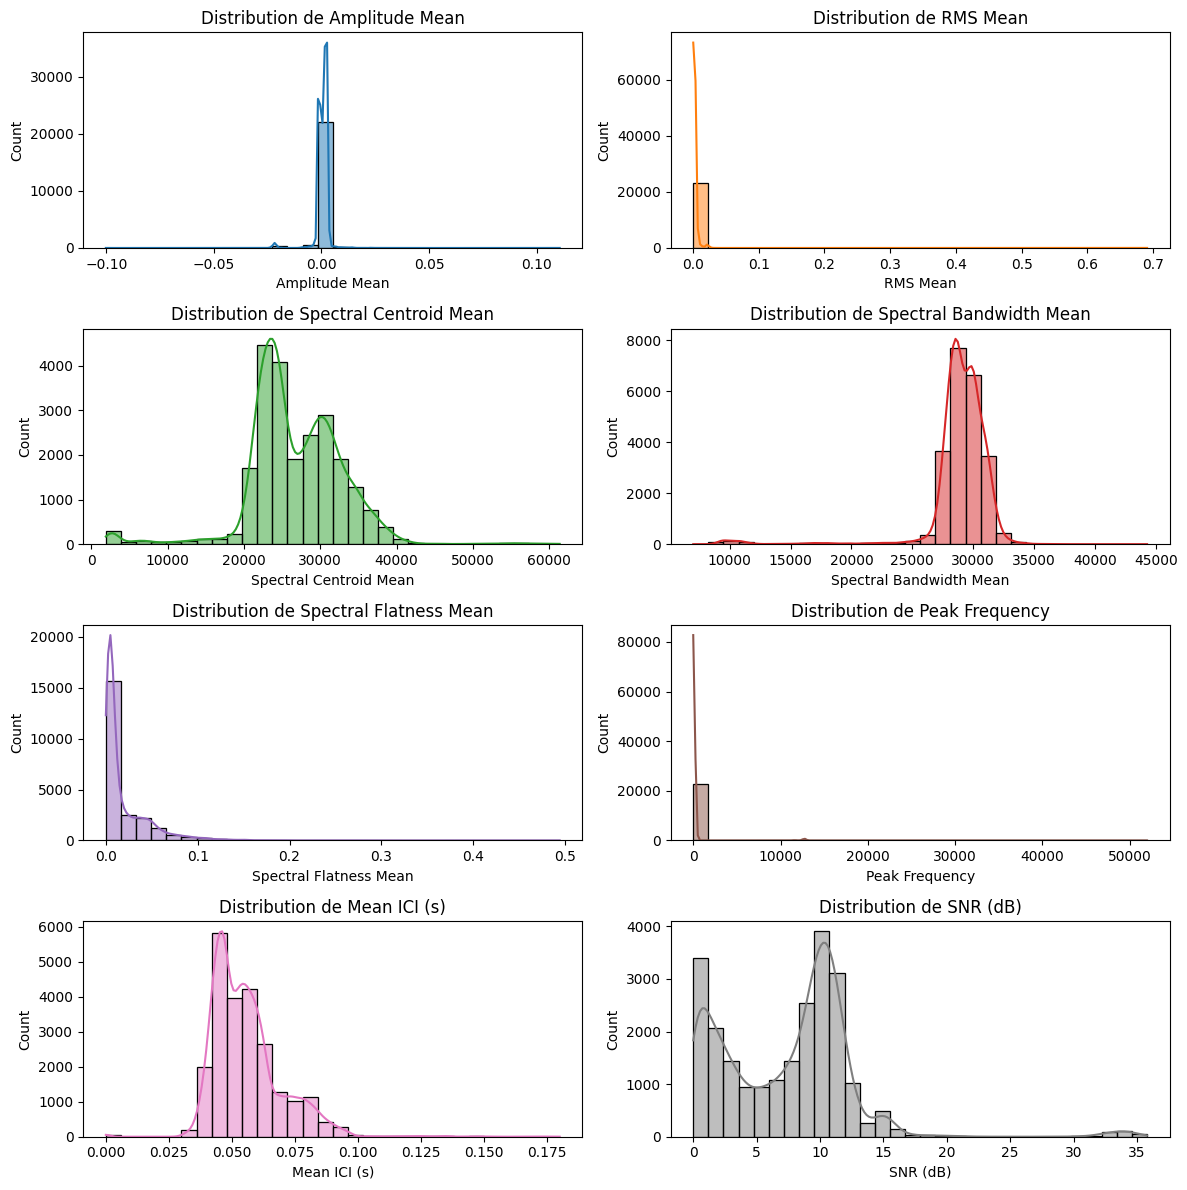

In [25]:
feature_pairs_mean = [
    ("Amplitude Mean", "RMS Mean"),
    ("Spectral Centroid Mean", "Spectral Bandwidth Mean"),
    ("Spectral Flatness Mean", "Peak Frequency"),
    ("Mean ICI (s)", "SNR (dB)")
]

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"]

fig, axes = plt.subplots(4, 2, figsize=(12, 12))

# Boucle 
for i, (feature1, feature2) in enumerate(feature_pairs_mean):
    sns.histplot(audio_df[feature1], kde=True, bins=30, color=colors[2*i], ax=axes[i, 0])
    axes[i, 0].set_title(f"Distribution de {feature1}")

    sns.histplot(audio_df[feature2], kde=True, bins=30, color=colors[2*i+1], ax=axes[i, 1])
    axes[i, 1].set_title(f"Distribution de {feature2}")

plt.tight_layout()
plt.show()


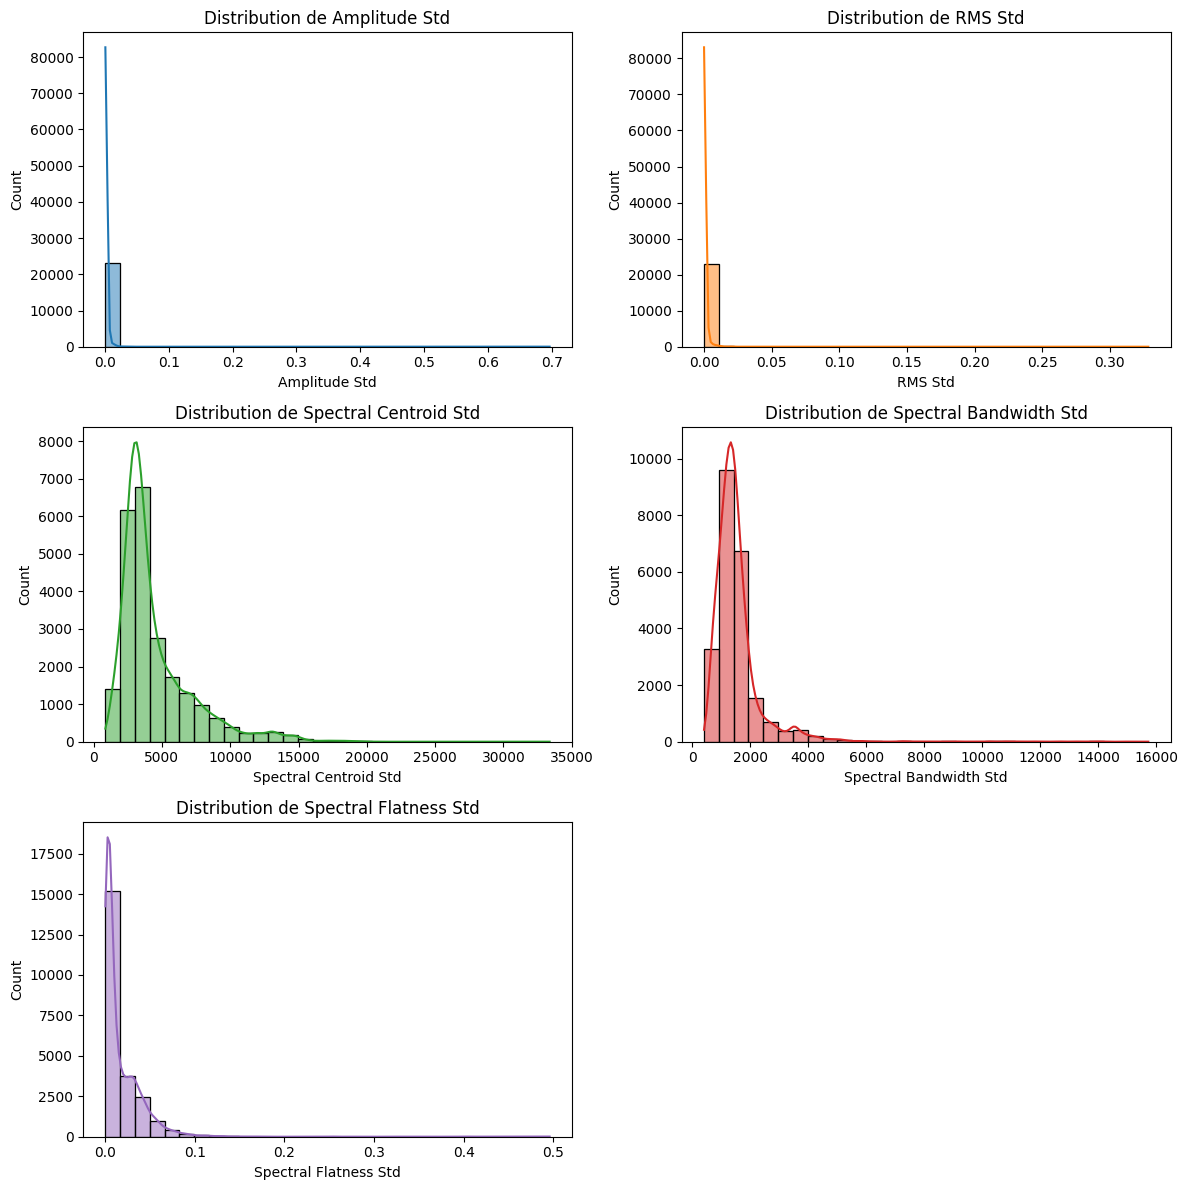

In [31]:
feature_pairs_std = [
    ("Amplitude Std", "RMS Std"),
    ("Spectral Centroid Std", "Spectral Bandwidth Std"),
    ("Spectral Flatness Std",)  
]

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Boucle pour afficher les histogrammes
for i, feature_pair in enumerate(feature_pairs_std):
    if len(feature_pair) == 2: 
        feature1, feature2 = feature_pair
        sns.histplot(audio_df[feature1], kde=True, bins=30, color=colors[2*i], ax=axes[i, 0])
        axes[i, 0].set_title(f"Distribution de {feature1}")
        sns.histplot(audio_df[feature2], kde=True, bins=30, color=colors[2*i+1], ax=axes[i, 1])
        axes[i, 1].set_title(f"Distribution de {feature2}")
    else:  
        feature1 = feature_pair[0]
        sns.histplot(audio_df[feature1], kde=True, bins=30, color=colors[2*i], ax=axes[i, 0])
        axes[i, 0].set_title(f"Distribution de {feature1}")
        axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


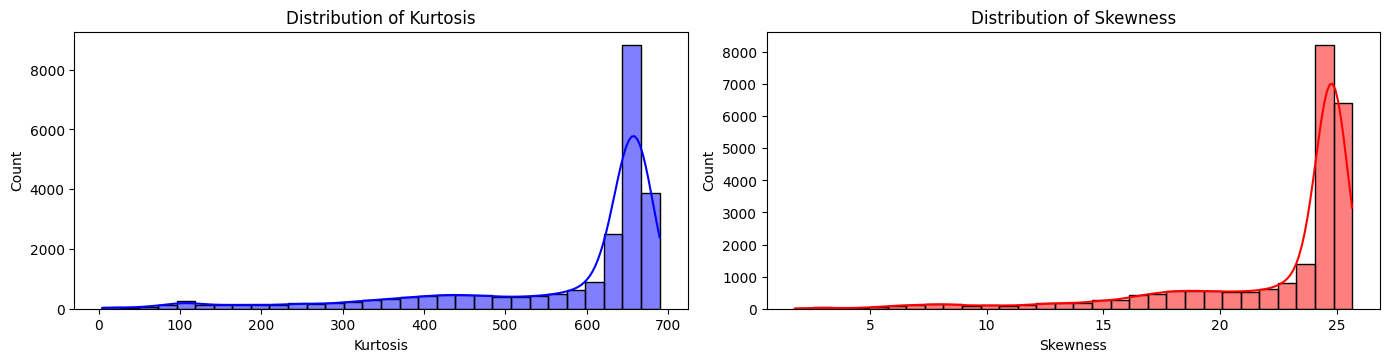

In [24]:
# Kurtosis et Skewness
plt.figure(figsize=(14, 10))

plt.subplot(3, 2, 1)
sns.histplot(audio_df["Kurtosis"], bins=30, kde=True, color="blue")
plt.xlabel("Kurtosis")
plt.ylabel("Count")
plt.title("Distribution of Kurtosis")

plt.subplot(3, 2, 2)
sns.histplot(audio_df["Skewness"], bins=30, kde=True, color="red")
plt.xlabel("Skewness")
plt.ylabel("Count")
plt.title("Distribution of Skewness")

plt.tight_layout()
plt.show()

In [21]:
# On va récupérer la target de la dataframe y_train
audio_df['File'] = audio_df['File'].str.split('/').str[-1]
audio_data = pd.merge(audio_df, y_train, left_on='File', right_on='id', how='inner')

In [46]:
audio_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Sampling Rate (Hz),23168.0,256000.000000,0.000000,2.560000e+05,256000.000000,256000.000000,256000.000000,256000.000000
Duration (s),23168.0,0.200000,0.000000,2.000000e-01,0.200000,0.200000,0.200000,0.200000
Peak Frequency,23168.0,146.586887,1426.668047,0.000000e+00,0.000000,0.000000,0.000000,52000.000000
Mean ICI (s),23168.0,0.055706,0.013815,0.000000e+00,0.046000,0.053333,0.061333,0.180000
SNR (dB),23168.0,7.406848,5.248986,1.035439e-06,2.634824,8.522837,10.620104,35.796864
Kurtosis,23168.0,575.947754,145.584366,4.627418e+00,545.017365,647.694550,661.952682,689.467224
Skewness,23168.0,22.470638,4.300125,1.773408e+00,21.730649,24.525545,24.904695,25.664991
Amplitude Mean,23168.0,0.000484,0.003523,-1.002599e-01,-0.001034,0.001000,0.002244,0.110766
Amplitude Std,23168.0,0.001672,0.017963,2.945912e-04,0.000488,0.000652,0.000864,0.696941
Amplitude Min,23168.0,-0.029305,0.061885,-8.022156e-01,-0.025482,-0.014069,-0.007782,0.015808


In [48]:
audio_data.columns

Index(['File', 'Sampling Rate (Hz)', 'Duration (s)', 'Peak Frequency',
       'Mean ICI (s)', 'SNR (dB)', 'Kurtosis', 'Skewness', 'Amplitude Mean',
       'Amplitude Std', 'Amplitude Min', 'Amplitude Max', 'RMS Mean',
       'RMS Std', 'RMS Min', 'RMS Max', 'Spectral Centroid Mean',
       'Spectral Centroid Std', 'Spectral Centroid Min',
       'Spectral Centroid Max', 'Spectral Bandwidth Mean',
       'Spectral Bandwidth Std', 'Spectral Bandwidth Min',
       'Spectral Bandwidth Max', 'Spectral Flatness Mean',
       'Spectral Flatness Std', 'Spectral Flatness Min',
       'Spectral Flatness Max', 'id', 'pos_label', 'location'],
      dtype='object')

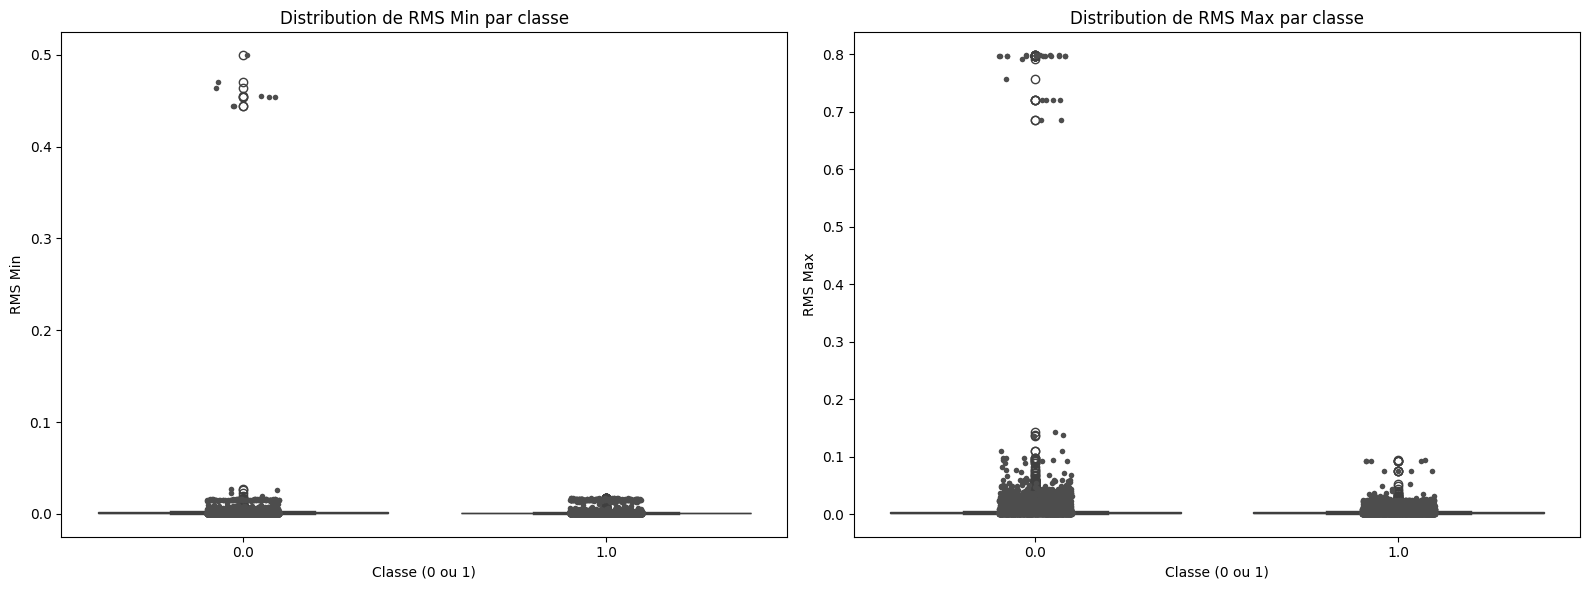


Statistiques pour RMS Min:
             count      mean      std  min       25%       50%       75%  \
pos_label                                                                  
0.0        13718.0  0.001554  0.01119  0.0  0.000734  0.001058  0.001661   
1.0         9450.0  0.001316  0.00210  0.0  0.000612  0.000965  0.001368   

                max  
pos_label            
0.0        0.499568  
1.0        0.017150  

Statistiques pour RMS Max:
             count      mean       std       min       25%       50%  \
pos_label                                                              
0.0        13718.0  0.005055  0.033578  0.000403  0.001632  0.002211   
1.0         9450.0  0.003675  0.005007  0.000465  0.001583  0.002099   

                75%       max  
pos_label                      
0.0        0.003021  0.798094  
1.0        0.003342  0.093820  


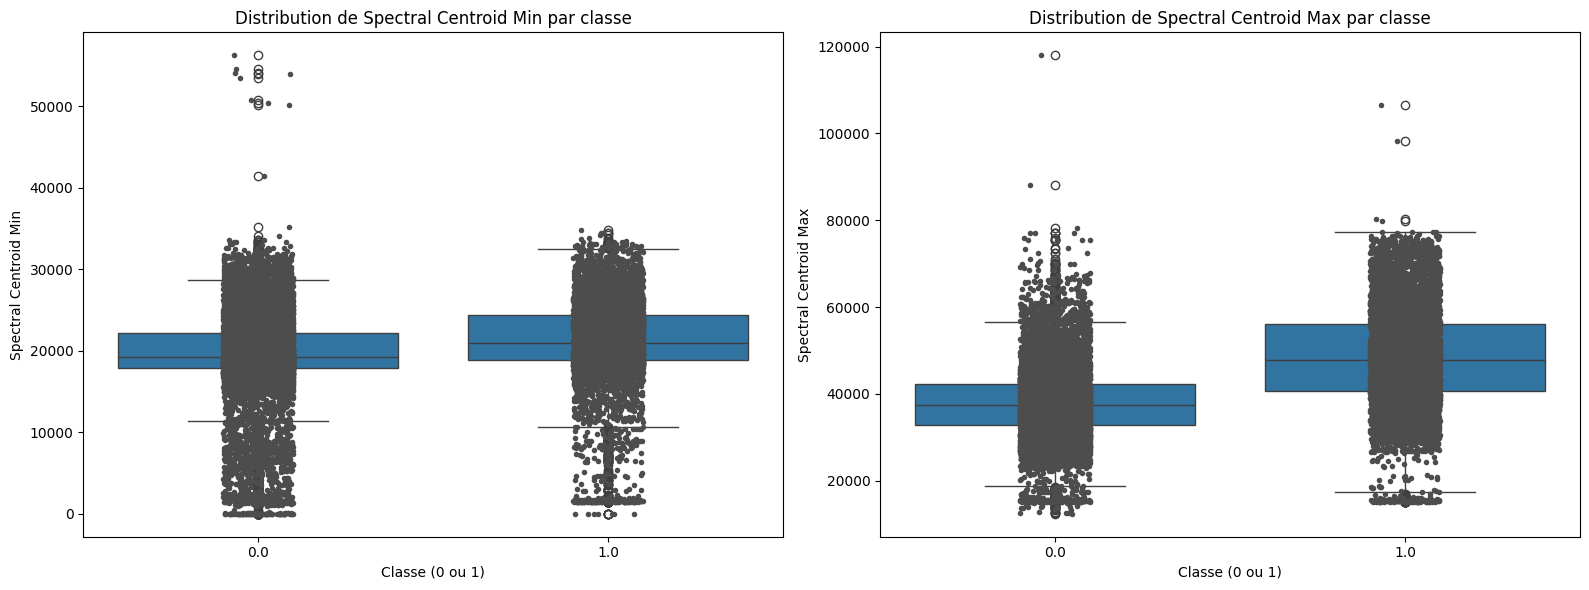


Statistiques pour Spectral Centroid Min:
             count          mean          std  min           25%  \
pos_label                                                          
0.0        13718.0  19544.473239  5283.176608  0.0  17869.026713   
1.0         9450.0  21163.060975  4918.823338  0.0  18874.024202   

                    50%           75%           max  
pos_label                                            
0.0        19263.010416  22209.912055  56254.902715  
1.0        20967.460195  24338.818144  34810.076511  

Statistiques pour Spectral Centroid Max:
             count          mean           std           min           25%  \
pos_label                                                                    
0.0        13718.0  37765.851946   8084.690861  12372.696119  32840.449587   
1.0         9450.0  48400.519905  11658.322876  15007.931533  40624.011851   

                    50%           75%            max  
pos_label                                             
0.0 

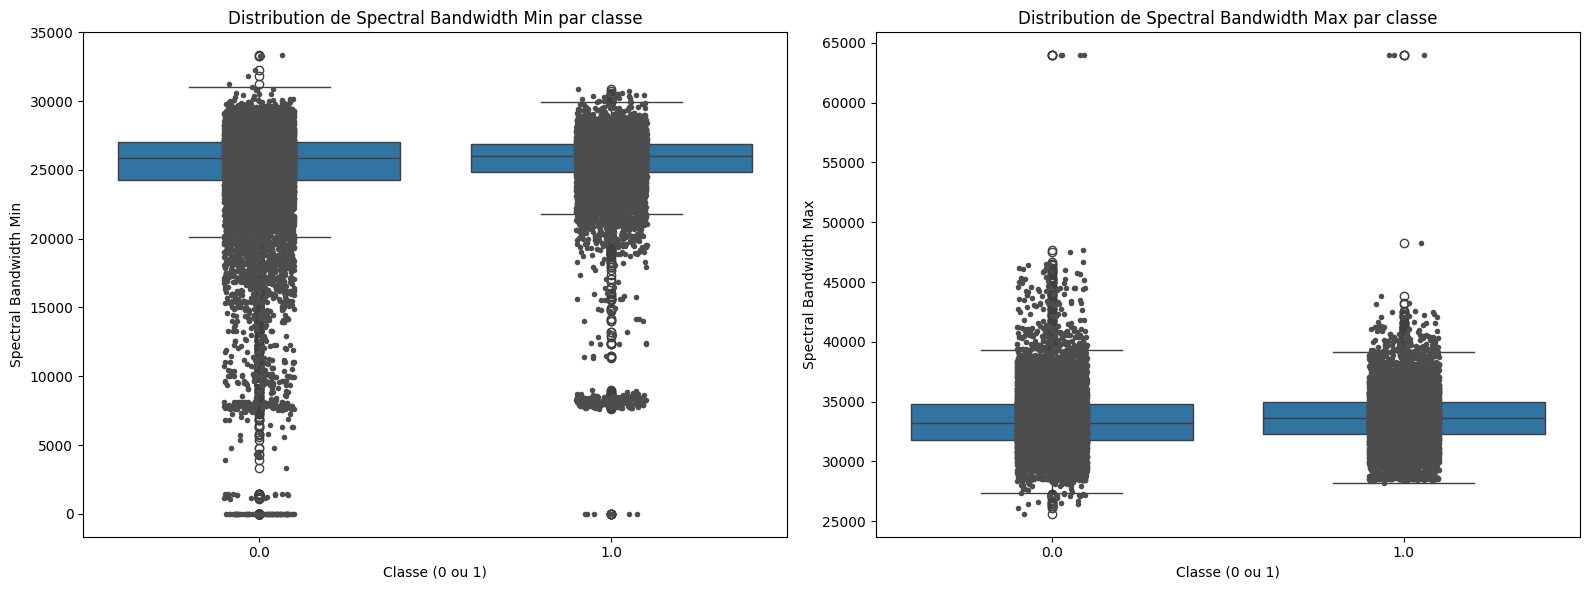


Statistiques pour Spectral Bandwidth Min:
             count          mean          std  min           25%  \
pos_label                                                          
0.0        13718.0  24952.920918  3934.128976  0.0  24261.498054   
1.0         9450.0  25355.271113  3133.797434  0.0  24828.310153   

                    50%           75%           max  
pos_label                                            
0.0        25900.893930  27025.594167  33340.084560  
1.0        26003.500831  26869.680918  30876.161688  

Statistiques pour Spectral Bandwidth Max:
             count          mean          std           min           25%  \
pos_label                                                                   
0.0        13718.0  33452.347867  2496.665240  25625.672703  31814.191269   
1.0         9450.0  33704.638666  2248.273747  28207.670516  32260.157347   

                    50%           75%           max  
pos_label                                            
0.0     

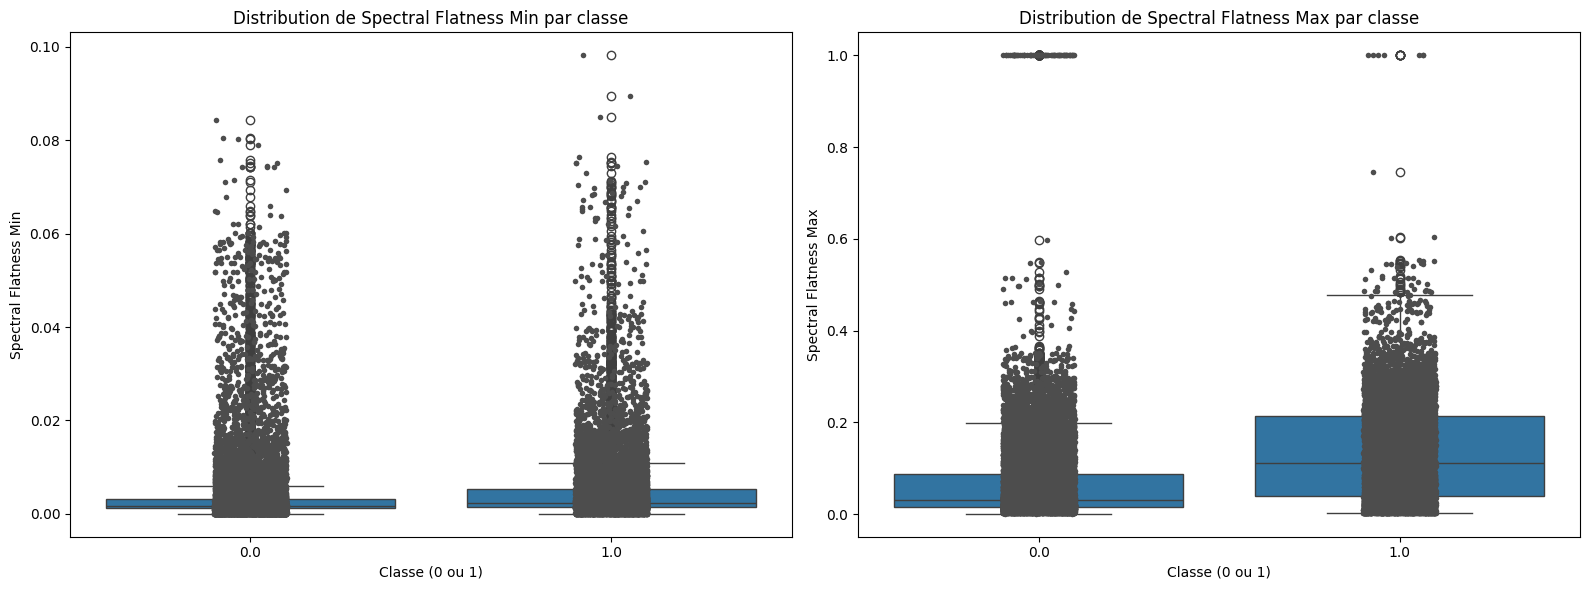


Statistiques pour Spectral Flatness Min:
             count      mean       std           min       25%       50%  \
pos_label                                                                  
0.0        13718.0  0.004020  0.007705  6.112999e-11  0.001223  0.001631   
1.0         9450.0  0.005173  0.007979  8.436548e-07  0.001464  0.002226   

                75%       max  
pos_label                      
0.0        0.003077  0.084266  
1.0        0.005204  0.098207  

Statistiques pour Spectral Flatness Max:
             count      mean       std       min       25%       50%  \
pos_label                                                              
0.0        13718.0  0.067792  0.097731  0.000524  0.014539  0.031571   
1.0         9450.0  0.132464  0.106605  0.001725  0.038692  0.112181   

                75%       max  
pos_label                      
0.0        0.087864  1.000001  
1.0        0.214480  1.000001  


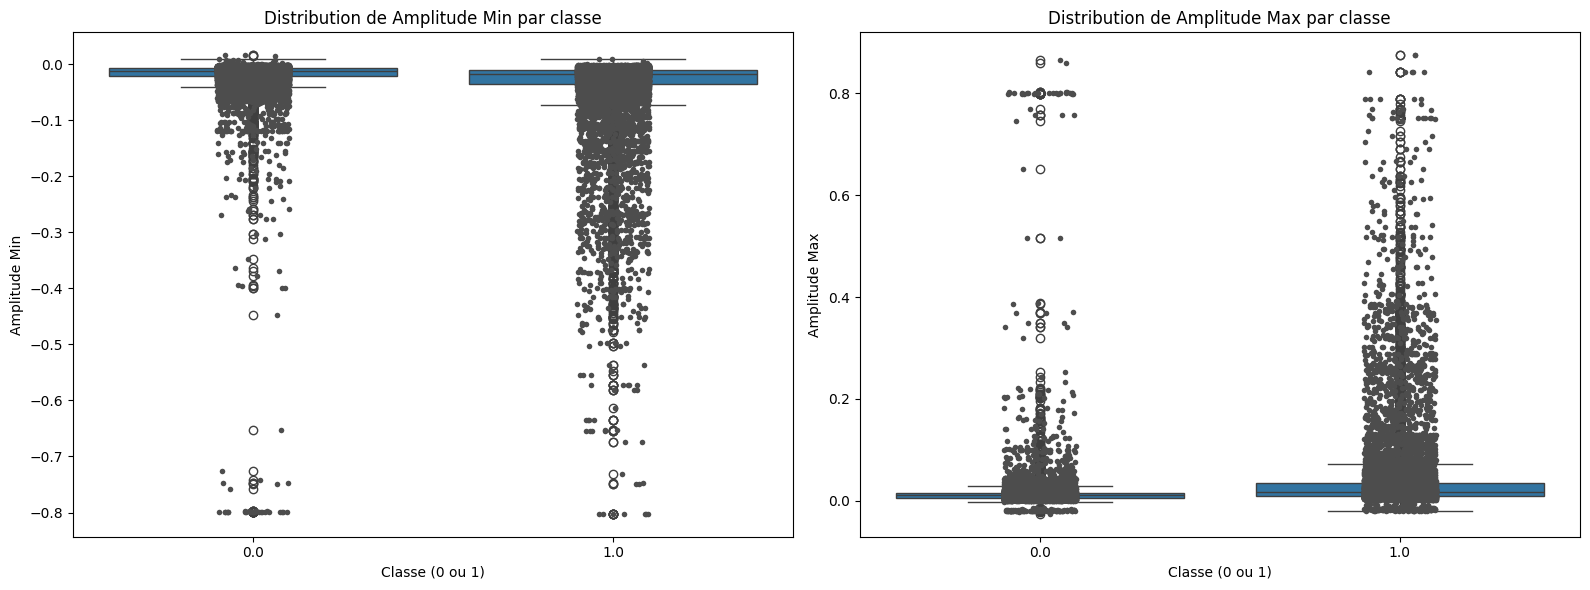


Statistiques pour Amplitude Min:
             count      mean       std       min       25%       50%  \
pos_label                                                              
0.0        13718.0 -0.019066  0.042905 -0.799225 -0.020325 -0.012146   
1.0         9450.0 -0.044168  0.079651 -0.802216 -0.034973 -0.018356   

                75%       max  
pos_label                      
0.0       -0.006927  0.015808  
1.0       -0.009613  0.008514  

Statistiques pour Amplitude Max:
             count      mean       std       min       25%       50%  \
pos_label                                                              
0.0        13718.0  0.014693  0.042498 -0.025574  0.006317  0.010773   
1.0         9450.0  0.046285  0.092428 -0.021057  0.009468  0.017792   

                75%       max  
pos_label                      
0.0        0.015068  0.864441  
1.0        0.034378  0.874664  


In [44]:
features_min_max = [
    ("RMS Min", "RMS Max"),
    ("Spectral Centroid Min", "Spectral Centroid Max"),
    ("Spectral Bandwidth Min", "Spectral Bandwidth Max"),
    ("Spectral Flatness Min", "Spectral Flatness Max"),
    ("Amplitude Min", "Amplitude Max")
]

# Sous-graphiques pour chaque paire de caractéristiques
for feature_min, feature_max in features_min_max:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Distribution de Min par pos_label
    sns.boxplot(x='pos_label', y=feature_min, data=audio_data, ax=axes[0])
    sns.stripplot(x='pos_label', y=feature_min, data=audio_data, 
                  size=4, color='.3', linewidth=0, ax=axes[0])
    axes[0].set_title(f'Distribution de {feature_min} par classe')
    axes[0].set_xlabel('Classe (0 ou 1)')
    axes[0].set_ylabel(feature_min)

    # Distribution de Max par pos_label
    sns.boxplot(x='pos_label', y=feature_max, data=audio_data, ax=axes[1])
    sns.stripplot(x='pos_label', y=feature_max, data=audio_data, 
                  size=4, color='.3', linewidth=0, ax=axes[1])
    axes[1].set_title(f'Distribution de {feature_max} par classe')
    axes[1].set_xlabel('Classe (0 ou 1)')
    axes[1].set_ylabel(feature_max)

    plt.tight_layout()
    plt.show()

    # Statistiques descriptives pour chaque variable
    print(f"\nStatistiques pour {feature_min}:")
    print(audio_data.groupby('pos_label')[feature_min].describe())
    print(f"\nStatistiques pour {feature_max}:")
    print(audio_data.groupby('pos_label')[feature_max].describe())


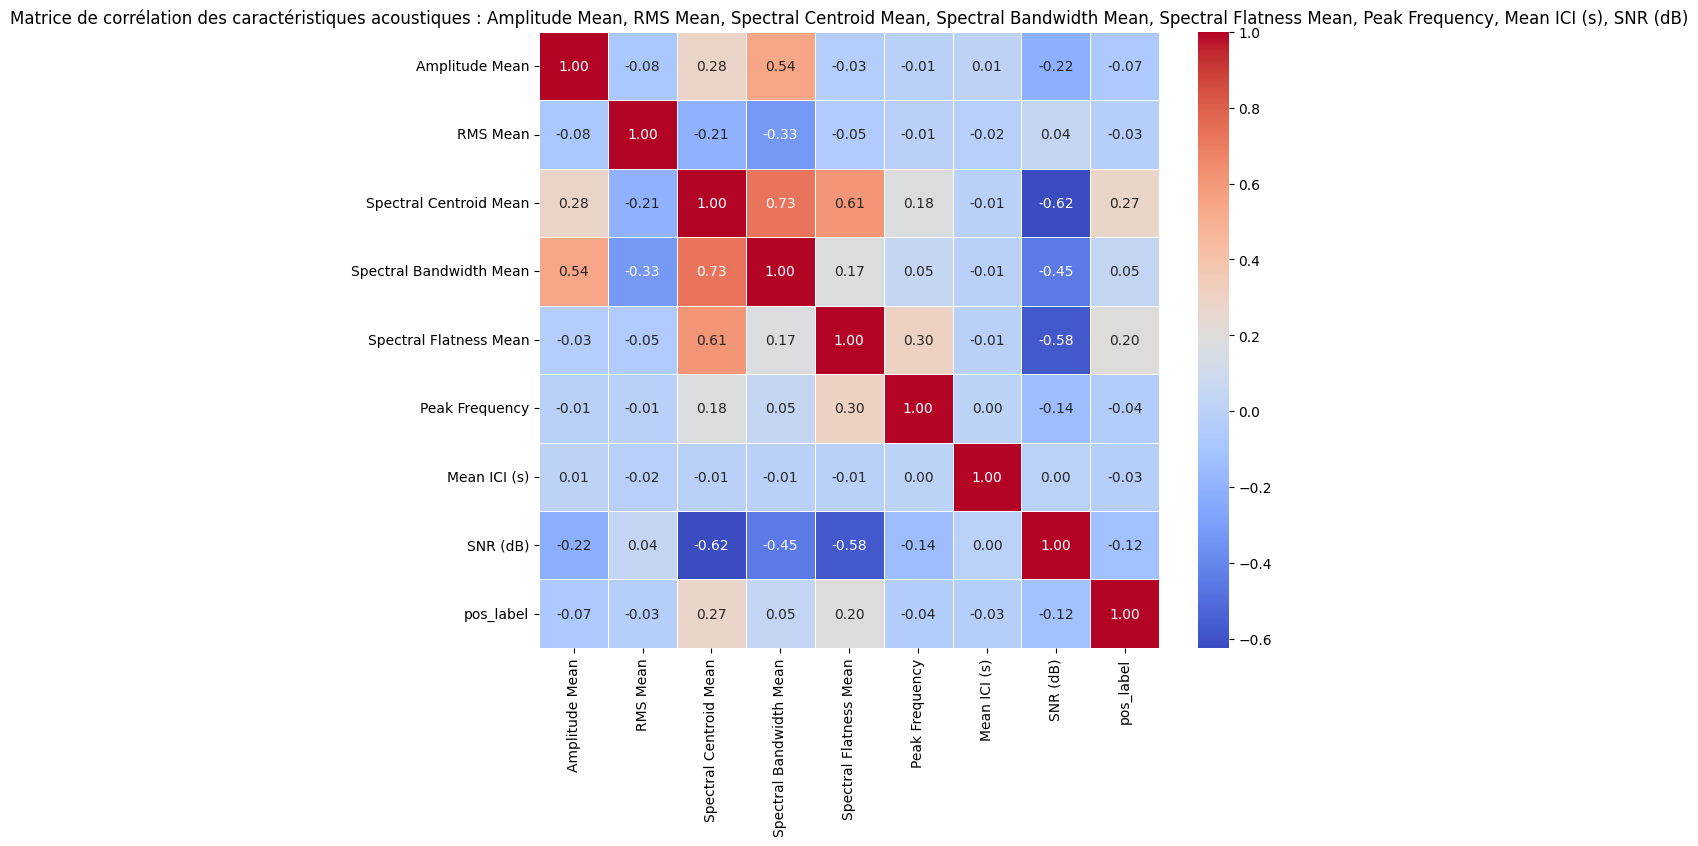

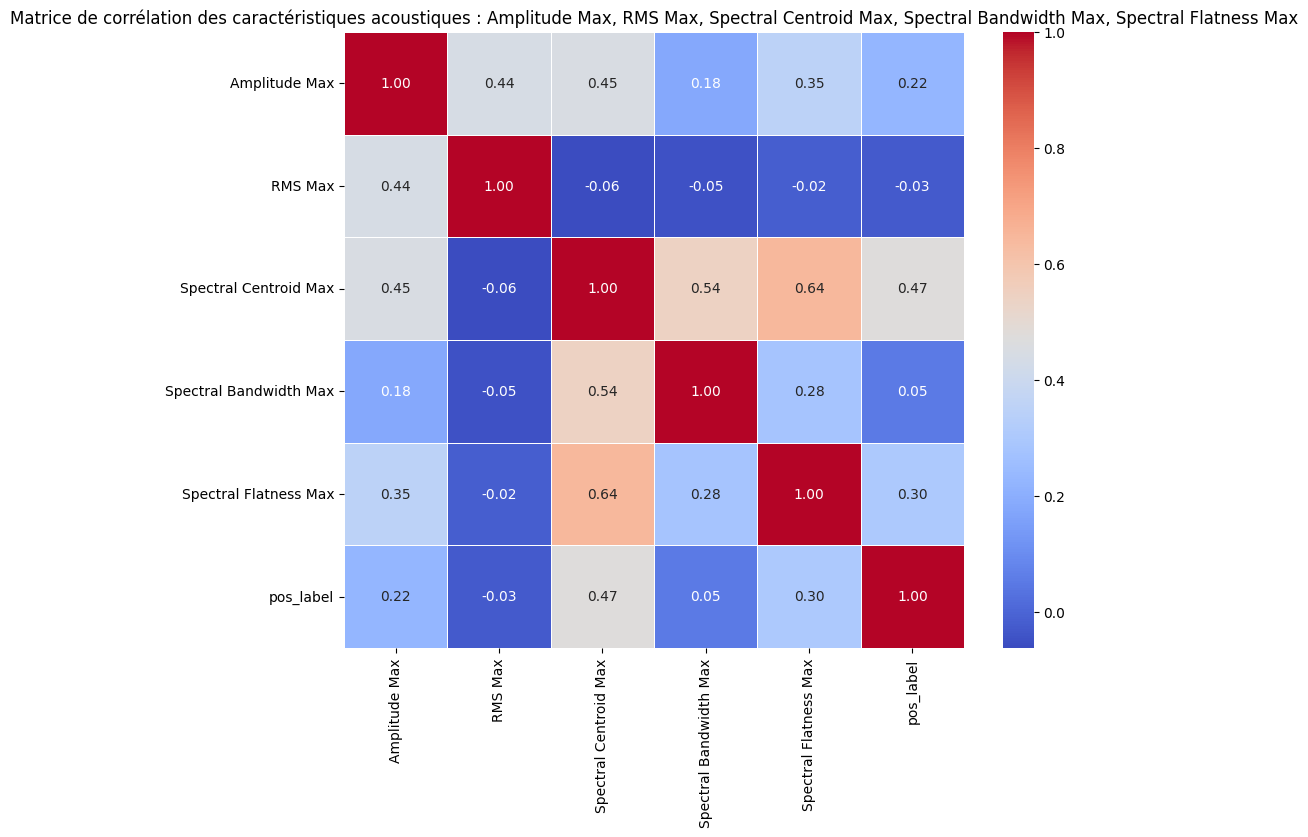

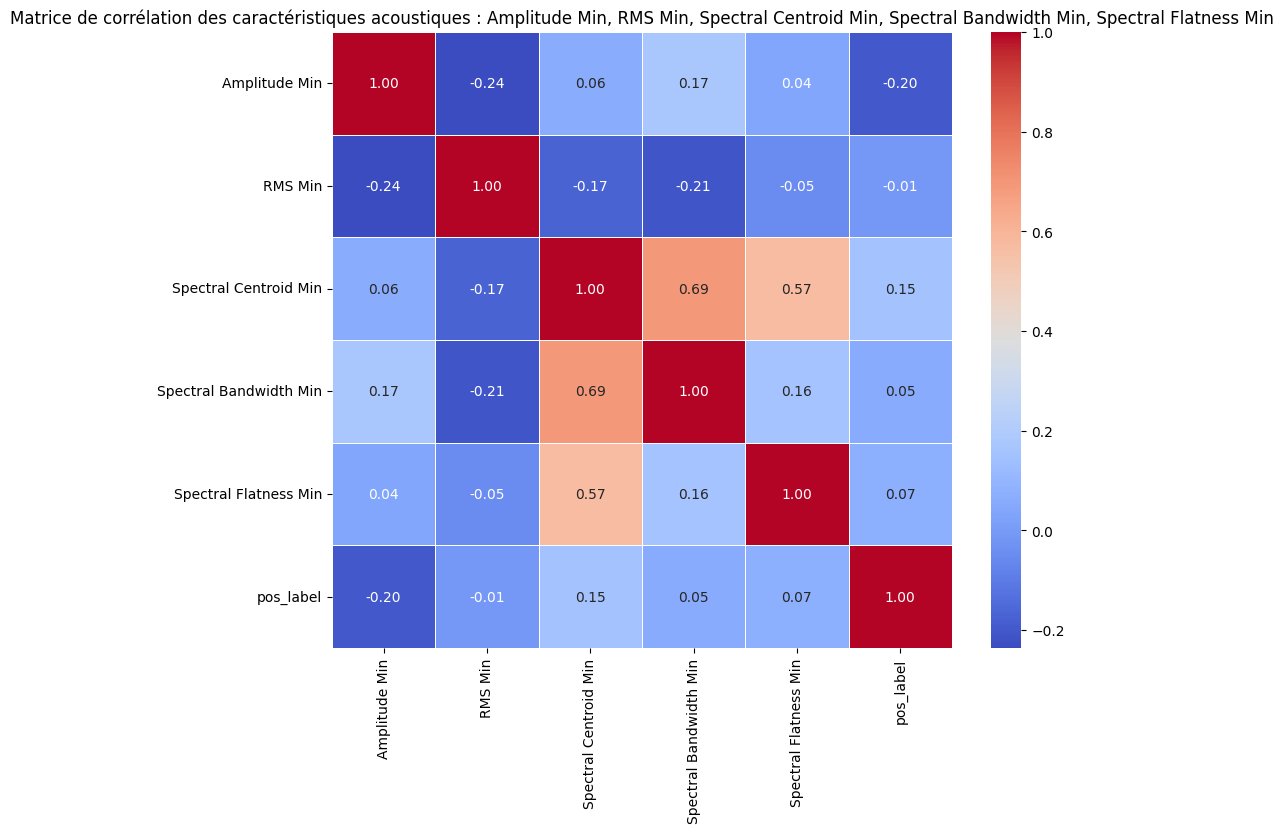

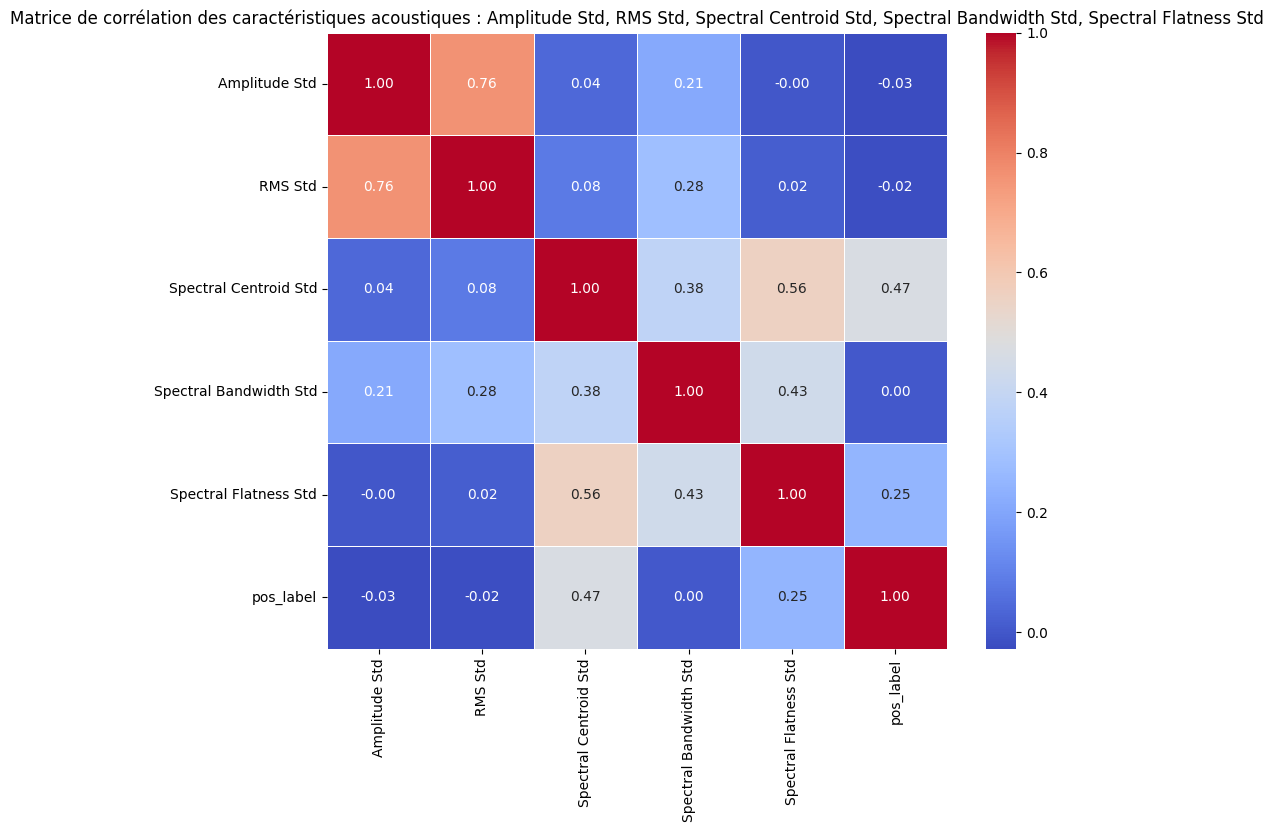

In [45]:
# Sélectionner les caractéristiques à analyser
selected_features_mean = [
    "Amplitude Mean", "RMS Mean", "Spectral Centroid Mean", 
    "Spectral Bandwidth Mean", "Spectral Flatness Mean", "Peak Frequency",
    "Mean ICI (s)", "SNR (dB)", "pos_label"
]

selected_features_max = [
    "Amplitude Max", "RMS Max", "Spectral Centroid Max", 
    "Spectral Bandwidth Max", "Spectral Flatness Max", "pos_label"
]

selected_features_min = [
    "Amplitude Min", "RMS Min", "Spectral Centroid Min", 
    "Spectral Bandwidth Min", "Spectral Flatness Min", "pos_label"
]

selected_features_std = [
    "Amplitude Std", "RMS Std", "Spectral Centroid Std", 
    "Spectral Bandwidth Std", "Spectral Flatness Std", "pos_label"
]

# Matrice de corrélation pour chaque groupe
features_list = [selected_features_mean, selected_features_max, selected_features_min, selected_features_std]

for selected_features in features_list:
    corr_matrix = audio_data[selected_features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title(f"Matrice de corrélation des caractéristiques acoustiques : {', '.join(selected_features[:-1])}")
    plt.show()


In [ ]:
#Crash test

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

/Users/maro/projet_dl/venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


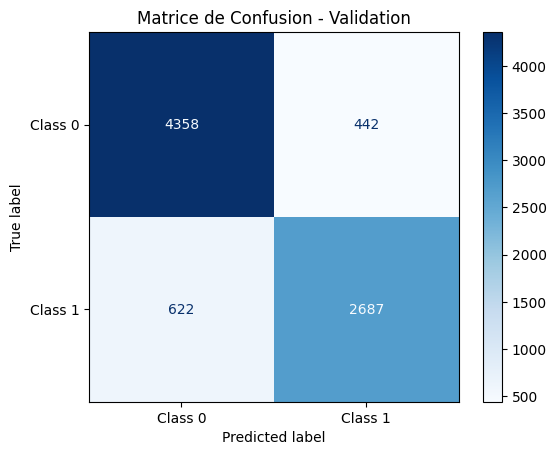

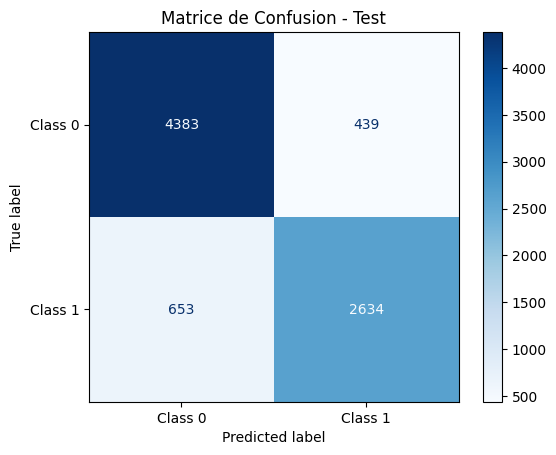

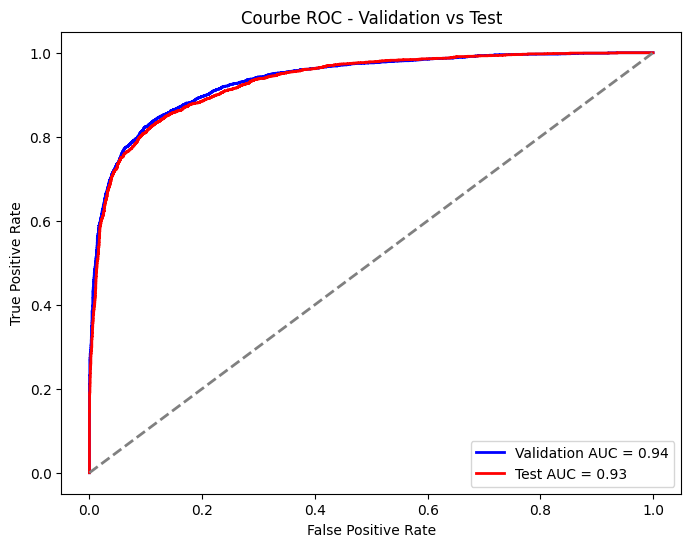

AUC sur l'ensemble de validation : 0.94
AUC sur l'ensemble de test : 0.93


In [59]:
# 1. On garde seulement les colonnes pertinentes
features = [
    "Amplitude Mean", "Amplitude Std", "Amplitude Min", "Amplitude Max",
    "RMS Mean", "RMS Std", "RMS Min", "RMS Max",
    "Spectral Centroid Mean", "Spectral Centroid Std", "Spectral Centroid Min", 
    "Spectral Centroid Max", "Spectral Bandwidth Mean", "Spectral Bandwidth Std", 
    "Spectral Bandwidth Min", "Spectral Bandwidth Max", "Spectral Flatness Mean", 
    "Spectral Flatness Std", "Spectral Flatness Min", "Spectral Flatness Max"
]

# Sélectionner les features et la cible
X = audio_data[features]
y = audio_data['pos_label']

# 2. Diviser les données en ensemble d'entraînement (80%) et validation (15%) et test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 3. Scaling des données (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# 4. Créer le modèle Random Forest avec class_weight='balanced'
rf_model = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    n_estimators=200,            # Nombre d'arbres
    max_depth=5,                 # Profondeur maximale des arbres
    min_samples_split=10,        # Nombre minimal d'échantillons pour diviser un noeud
    min_samples_leaf=4,          # Nombre minimal d'échantillons dans une feuille
    max_features='sqrt',         # Nombre maximal de caractéristiques à considérer pour chaque arbre
    bootstrap=True,              # Utiliser des échantillons bootstrap
    criterion='entropy',        # Critère utilisé pour la division des noeuds
    oob_score=True,              # Calcul de l'accuracy sur les échantillons hors sac
    warm_start=True              # Ajouter des arbres au modèle sans repartir de zéro
)

rf_model.fit(X_train_scaled, y_train)


# 5. Prédictions sur l'ensemble de validation
y_valid_pred = rf_model.predict(X_valid_scaled)
y_valid_pred_prob = rf_model.predict_proba(X_valid_scaled)[:, 1]  # Probabilités pour la classe 1

# 6. Prédictions sur l'ensemble de test
y_test_pred = rf_model.predict(X_test_scaled)
y_test_pred_prob = rf_model.predict_proba(X_test_scaled)[:, 1]  # Probabilités pour la classe 1

# 7. Matrice de confusion pour la validation
cm_valid = confusion_matrix(y_valid, y_valid_pred)
disp_valid = ConfusionMatrixDisplay(confusion_matrix=cm_valid, display_labels=["Class 0", "Class 1"])
disp_valid.plot(cmap="Blues")
plt.title("Matrice de Confusion - Validation")
plt.show()

# Matrice de confusion pour le test
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Class 0", "Class 1"])
disp_test.plot(cmap="Blues")
plt.title("Matrice de Confusion - Test")
plt.show()

# 8. Calcul de l'AUC pour la validation
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_pred_prob)
roc_auc_valid = auc(fpr_valid, tpr_valid)

# Calcul de l'AUC pour le test
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Tracer la courbe ROC pour la validation et le test
plt.figure(figsize=(8, 6))

# Courbe ROC - Validation
plt.plot(fpr_valid, tpr_valid, color='blue', lw=2, label=f'Validation AUC = {roc_auc_valid:.2f}')

# Courbe ROC - Test
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test AUC = {roc_auc_test:.2f}')

# Diagonale
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC - Validation vs Test')
plt.legend(loc='lower right')
plt.show()

# Affichage des AUC pour validation et test
print(f'AUC sur l\'ensemble de validation : {roc_auc_valid:.2f}')
print(f'AUC sur l\'ensemble de test : {roc_auc_test:.2f}')
